# Track cells over time

In [1]:
import matplotlib.pyplot as plt

import cv2
import natsort
import numpy as np
import os
import glob
import pandas as pd
import sys
import trackpy as tp
import scipy.misc
import skimage.filters
import sklearn.metrics

plt.ion()

1. Martin Maška, Vladimír Ulman, David Svoboda, Pavel Matula, Petr Matula, Cristina Ederra, Ainhoa Urbiola, Tomás España, Subramanian Venkatesan, Deepak M.W. Balak, Pavel Karas, Tereza Bolcková, Markéta Štreitová, Craig Carthel, Stefano Coraluppi, Nathalie Harder, Karl Rohr, Klas E. G. Magnusson, Joakim Jaldén, Helen M. Blau, Oleh Dzyubachyk, Pavel Křížek, Guy M. Hagen, David Pastor-Escuredo, Daniel Jimenez-Carretero, Maria J. Ledesma-Carbayo, Arrate Muñoz-Barrutia, Erik Meijering, Michal Kozubek, Carlos Ortiz-de-Solorzano; A benchmark for comparison of cell tracking algorithms, Bioinformatics, Volume 30, Issue 11, 1 June 2014, Pages 1609–1617, https://doi.org/10.1093/bioinformatics/btu080
2. Ulman, Vladimír & Maška, Martin & E G Magnusson, Klas & Ronneberger, Olaf & Haubold, Carsten & Harder, Nathalie & Matula, Pavel & Matula, Petr & Svoboda, David & Radojevic, Miroslav & Smal, Ihor & Rohr, Karl & Jaldén, Joakim & Blau, Helen & Dzyubachyk, Oleh & Lelieveldt, Boudewijn & Xiao, Pengdong & Li, Yuexiang & Cho, Siu-Yeung & Ortiz-de-Solorzano, Carlos. (2017). An Objective Comparison of Cell Tracking Algorithms. Nature Methods. 14. 10.1038/nmeth.4473. 


In [3]:
DATA_DIR = os.path.join(os.getcwd(), "data")
GRAYSCALE_DIR = os.path.join(DATA_DIR,"grayscale") + os.sep
GROUNDTRUTH_SEGMENTED_DIR = os.path.join(DATA_DIR, "groundtruth_segmentation") + os.sep
GROUNDTRUTH_TRACKING_DIR = os.path.join(DATA_DIR, "groundtruth_tracking") + os.sep
LI_THRESHOLDED_DIR = os.path.join(DATA_DIR, "li_thresholded") + os.sep
YEN_THRESHOLDED_DIR = os.path.join(DATA_DIR, "yen_thresholded") + os.sep
OTSU_THRESHOLDED_DIR = os.path.join(DATA_DIR, "otsu_thresholded") + os.sep
CONFUSION_MATRIX_MASK_DIR = os.path.join(DATA_DIR, "confusion_matrix") + os.sep

GRAYSCALE_IMAGES = natsort.natsorted(glob.glob(GRAYSCALE_DIR + "*.tif"))
GROUNDTRUTH_SEGMENTED_IMAGES = natsort.natsorted(glob.glob(GROUNDTRUTH_SEGMENTED_DIR + "*.tif"))
GROUNDTRUTH_TRACKING_IMAGES = natsort.natsorted(glob.glob(GROUNDTRUTH_TRACKING_DIR + "*.tif"))

print("number of grayscale images are {}".format(len(GRAYSCALE_IMAGES)))
print("number of images manually segmented are {}".format(len(GROUNDTRUTH_SEGMENTED_IMAGES)))
print("number of images manually tracked are {}".format(len(GROUNDTRUTH_TRACKING_IMAGES)))
      
# Not all images are manually segmented, collect the subset of grayscale images that are manually segmented
data_files = []
for data in GRAYSCALE_IMAGES:
    for groundtruth in GROUNDTRUTH_SEGMENTED_IMAGES:
        if os.path.basename(groundtruth) == os.path.basename(data):
            data_files.append(data)

print("obtained {} number of grayscale images that are manually segmented".format(len(data_files)))

# To generate a video/gif from images in a folder/directory using ffmpeg run
# ffmpeg -framerate 5 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p out.mp4

number of grayscale images are 48
number of images manually segmented are 18
number of images manually tracked are 48
obtained 18 number of grayscale images that are manually segmented


SCALING TO UINT8

In [4]:
def convert_to_uint8(image):
    pmin, pmax = np.percentile(image, (0, 100))
    clipped_image = np.clip(image, pmin, pmax)
    clipped_image = (clipped_image - pmin) / (pmax - pmin)
    clipped_image = (255 * clipped_image).astype(np.uint8)
    return clipped_image

# SEGMENTATION/THRESHOLDING USING SKIMAGE 

/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum


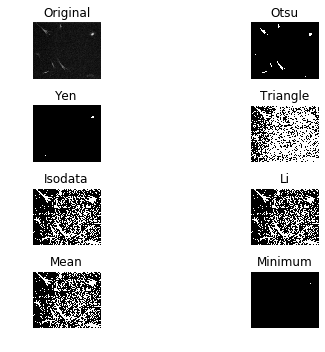

In [125]:
image = convert_to_uint8(scipy.misc.imread(data_files[0]))
image = skimage.filters.median(image)
result = skimage.filters.thresholding.try_all_threshold(image)

1. Otsu threshold - The algorithm assumes that the image contains two classes of pixels following bi-modal histogram (foreground pixels and background pixels), it then calculates the optimum threshold separating the two classes so that their combined spread (intra-class variance) is minimal, or equivalently (because the sum of pairwise squared distances is constant), so that their inter-class variance is maximal

2. Circular thresholding is an algorithm for automatic image threshold selection in image processing. Most threshold selection algorithms assume that the values (e.g. intensities) lie on a linear scale. However, some quantities such as hue and orientation are a circular quantity, and therefore require circular thresholding algorithms. https://en.wikipedia.org/wiki/Circular_thresholding. Li thresholding smooths the circular histogram, and applies Otsu's Method. The histogram is cyclically rotated so that the selected threshold is shifted to zero. Otsu's Method and histogram rotation are applied iteratively until several heuristics involving class size, threshold location, and class variance are satisfied.

In [5]:
def segment_im(im, method):
    """
    Return a binary image with 0's and 255's after using threshold calculated by using the given "method"
    """
    return np.uint8(im > method(im)) * 255


def save_thresholded_images(data_files, thresholded_files_save_path, segmentation_method, create_folder_if_doesnt_exist=True):
    """
    Saves the thresholded images in thresholded_files_save_path folder after thresholding images in data_files
    using segmentation_method
    """
    if create_folder_if_doesnt_exist and not os.path.exists(thresholded_files_save_path):
        os.makedirs(thresholded_files_save_path)
    thresholded_files = []
    for index, file_name in enumerate(data_files):
        image = convert_to_uint8(scipy.misc.imread(file_name))
        image = skimage.filters.median(image)
        thresholded_image = segment_im(image, segmentation_method)
        thresholded_file = thresholded_files_save_path + os.path.basename(file_name)
        scipy.misc.imsave(thresholded_file, thresholded_image)
        thresholded_files.append(thresholded_file)
    return thresholded_files

# Validation metrics

Takeaway - Matthew Correlation Coefficient -https://lettier.github.io/posts/2016-08-05-matthews-correlation-coefficient.html

In [15]:
def get_validation_metrics(groundtruth, predicted):
    """
    Return validation metrics dictionary with accuracy, f1 score, mcc after
    comparing ground truth and predicted image

    :param groundtruth list of ground truth labels with binary values
    :param predicted list of predicted labels with binary values
    :return returns a dictionary with accuracy,f1 score, tp, tn, fp, fn, and mcc as keys
    """
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth, predicted).ravel()
    validation_metrics = {}

    validation_metrics["tp"] = tp
    validation_metrics["fp"] = fp
    validation_metrics["fn"] = fn
    validation_metrics["tn"] = tn
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    validation_metrics["accuracy"] = accuracy
    f1_score = 2 * tp / ((2 * tp) + fp + fn)
    validation_metrics["f1_score"] = f1_score
    
    tn = np.float64(tn)
    fp = np.float64(fp)
    fn = np.float64(fn)
    tp = np.float64(tp)
    
    # edge cases
    if (tp == 0 and fp == 0):
        mcc = 0
    elif (tn == 0 and fn == 0):
        mcc = 0
    elif (fp == 0 and fn == 0):
        mcc = 1
    elif (tp == 0 and tn == 0):
        mcc = -1
    elif (tp == 0 and fn == 0):
        mcc = 0
    elif (tn == 0 and fp == 0):
        mcc = 0
    else:
        mcc = ((tp * tn) - (fp * fn)) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
           
    validation_metrics["mcc"] = mcc
    return validation_metrics

def get_avg_validation_metrics(
    groundtruth_files,
    predicted_files):
    """
    Comparing ground truth and predicted using accuracy, f1 score, mcc

    :param groundtruth
    :param predicted
    :return returns a dictionary with accuracy,f1 score, tp, tn, fp, fn, and mcc as keys
    """   
    validation_metrics_agg = []
    
    for index, file_name in enumerate(groundtruth_files):
        image =  scipy.misc.imread(groundtruth_files[index])
        image[image != 0] = 255
        ground_truth_image = image // 255
        threshold_image = scipy.misc.imread(predicted_files[index]) // 255
        validation_metrics_agg.append(get_validation_metrics(
            ground_truth_image.flatten().tolist(),
            threshold_image.flatten().tolist()))
    validation_metrics_avg = {key: np.mean([metric_dict[key] for metric_dict in validation_metrics_agg]) for key, _ in validation_metrics_agg[0].items()}
    return validation_metrics_avg

Get validation metrics comparing 1.li and ground truth 2. otsu threshold  and ground truth 

In [16]:
li_thresholded_files = save_thresholded_images(data_files, LI_THRESHOLDED_DIR, skimage.filters.threshold_li)
validation_metrics_avg = get_avg_validation_metrics(GROUNDTRUTH_SEGMENTED_IMAGES,li_thresholded_files)
print("Li Thresholding")
print(validation_metrics_avg)

/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:60: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Li Thresholding
{'fn': 5137.6111111111113, 'f1_score': 0.1885624533969873, 'tp': 29238.388888888891, 'tn': 547913.61111111112, 'fp': 243054.38888888888, 'mcc': 0.22389837704808865, 'accuracy': 0.69928660049627789}


In [17]:
yen_thresholded_files = save_thresholded_images(data_files, YEN_THRESHOLDED_DIR, skimage.filters.threshold_yen)
validation_metrics_avg = get_avg_validation_metrics(GROUNDTRUTH_SEGMENTED_IMAGES,yen_thresholded_files)
print("Yen Thresholding")
print(validation_metrics_avg)

/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:60: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Yen Thresholding
{'fn': 32235.111111111109, 'f1_score': 0.088665076780835447, 'tp': 2140.8888888888887, 'tn': 790360.9444444445, 'fp': 607.05555555555554, 'mcc': 0.15321192785964471, 'accuracy': 0.96020790522901167}


In [18]:
otsu_thresholded_files = save_thresholded_images(data_files, OTSU_THRESHOLDED_DIR, skimage.filters.threshold_otsu)
validation_metrics_avg = get_avg_validation_metrics(GROUNDTRUTH_SEGMENTED_IMAGES, otsu_thresholded_files)
print("Otsu Thresholding")
print(validation_metrics_avg)

/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:60: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Otsu Thresholding
{'fn': 23403.388888888891, 'f1_score': 0.38726369911975328, 'tp': 10972.611111111111, 'tn': 783341.77777777775, 'fp': 7626.2222222222226, 'mcc': 0.42021316740731446, 'accuracy': 0.96240402655000679}


In [19]:
def images_to_npy(im_names):
    """
    Loads all images and converts them to a numpy stack

    Inputs:
    data_dir = list of images

    Outputs:
    returns image stack as (z stack, tile size_x, tile size_y)
    """
    shape = scipy.misc.imread(im_names[0]).shape
    im_stack = np.zeros((len(im_names), shape[0], shape[1]), dtype=np.uint8)
    for i in range(len(im_names)):
        im = scipy.misc.imread(im_names[i])
        im[im != 0] = 255
        im_stack[i, :, :] = im

    return im_stack

In [132]:
segmented_groundtruth_stack = images_to_npy(GROUNDTRUTH_SEGMENTED_IMAGES)

[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
[0 1 2]
[ 0  1  2  3  4  6  7  8 10]
[ 0  1  2  3  4  6  7  8  9 10]
[0 1 2 3 4 6 7 8 9]


/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


[0 1 2 3 4 5 6 7 8]
[0 1 2]
[ 0  1  2  3  4  5  6  7  8  9 10]
[0 1 2]
[0 1 2]
[ 0  1  2  3  4  5  6  7  8  9 10]
[ 0  1  2  3  4  5  6  7  8  9 10]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1 2]
[0 1 2 3 4 5 6 7 9]
[0 1 2]
[0 1 2]


In [133]:
# Look at first frame - a rough estimate of feature size
for diameter in range(10, 200):
    if diameter % 2 != 0:
        print(diameter)
        cell_df = tp.locate(segmented_groundtruth_stack[0, :, :], diameter=diameter)
        print(cell_df.head())
        print("Detected cells:", cell_df.shape[0])

11
           y           x         mass      size       ecc      signal  \
0  10.432203   53.487288  2757.333098  3.259710  0.273896   80.487124   
1  19.384796  401.964113  4431.335467  2.695308  0.317209  165.517877   
2  31.666667   61.190183  2843.012940  3.010067  0.301139   96.065277   
3  35.841038  400.500436  2976.725421  3.170198  0.323012   84.381663   
5  42.529356   75.531071  3405.124631  3.401660  0.141038   80.487124   

   raw_mass        ep  
0   15810.0  0.037594  
1   10710.0  0.055854  
2   15555.0  0.038219  
3   15810.0  0.037594  
5   17085.0  0.034754  
Detected cells: 143
13
           y           x         mass      size       ecc      signal  \
0  11.325211   51.875271  5836.090971  4.072800  0.047286   84.479001   
2  20.533561  401.812080  6597.105969  3.362860  0.433860  179.517877   
3  30.619193   62.306875  5303.873266  3.905490  0.108604  104.190768   
4  39.140928  390.485614  3596.693458  3.423892  0.317053  100.670809   
5  41.667031   76.293139  

            y           x          mass       size       ecc      signal  \
0   28.508940   63.962390  59350.791714  10.856231  0.577852  179.261263   
3   99.044399  399.340782  71193.745584  11.605701  0.162900  167.550728   
4  138.873622  890.591109  57671.681194  11.824044  0.360155  136.923175   
6  136.166788  246.360753  74116.875219  10.000290  0.290287  194.575039   
7  148.156609  826.312717  55650.262735  11.011904  0.222397  158.542624   

   raw_mass   ep  
0   97920.0  0.0  
3  212415.0  0.0  
4  218025.0  0.0  
6  125970.0  0.0  
7  203745.0  0.0  
Detected cells: 24
41
            y           x          mass       size       ecc      signal  \
0   28.528745   64.048102  64663.905499  11.546112  0.599351  182.755851   
3   98.448559  398.796699  78599.491474  12.058608  0.157547  169.184872   
4  140.233686  891.529293  65677.205265  12.537689  0.366473  138.423986   
6  136.115085  245.978522  78645.632802  10.320106  0.301957  197.231562   
8  177.282018  231.403413  

             y           x           mass       size       ecc      signal  \
0    88.810448  395.466596  209671.469340  19.336924  0.169986  181.292572   
2   149.910308  888.161901  207665.920261  19.902363  0.183435  157.686769   
3   136.067289  241.349497  116834.564675  14.957256  0.406159  216.229162   
10  191.168346  200.852838  120439.643011  18.845448  0.520556  212.452233   
12  465.489808   88.190827  168052.549009  20.872094  0.439727  205.842608   

    raw_mass   ep  
0   407745.0  0.0  
2   542385.0  0.0  
3   181050.0  0.0  
10  198135.0  0.0  
12  299370.0  0.0  
Detected cells: 16
69
             y           x           mass       size       ecc      signal  \
0    87.994072  395.394177  223804.736112  20.051154  0.185809  182.236804   
5   151.001117  887.807992  224895.324242  20.436000  0.167016  158.631001   
11  190.532454  201.314964  127084.204627  19.745754  0.505203  212.452233   
12  465.389232   88.147293  170547.210341  21.697996  0.486388  205.842608   

             y           x           mass       size       ecc      signal  \
7    79.472046  394.245607  412910.065279  27.262385  0.329468  196.711601   
28  151.502881  228.557383  305455.875533  31.141396  0.218039  211.990172   
35  556.111001  363.667976  294807.666466  27.997480  0.519784  212.945083   
37  575.826055  267.260671  114323.817226  29.758940  0.618307  241.592404   
38  516.589196   96.625248  120385.590265  28.106799  0.736360  241.592404   

    raw_mass   ep  
7   600015.0  0.0  
28  497760.0  0.0  
35  437070.0  0.0  
37  140250.0  0.0  
38  156825.0  0.0  
Detected cells: 7
97
             y           x           mass       size       ecc      signal  \
0   150.910580  227.876372  311535.495038  31.893283  0.265305  212.340881   
19  557.147546  364.069868  310747.072394  28.537604  0.516201  213.293082   
24  515.849737   96.346530  124272.738643  28.854544  0.743420  240.906919   
28  728.173539  352.278969   99374.580097  24.362789  0.794253  241.859120   


             y           x           mass       size       ecc      signal  \
0   173.278444  208.322259  398237.760778  37.574358  0.438405  220.978453   
7   504.688837   91.923369  199375.407550  40.125058  0.827855  241.154747   
8   586.259554  273.842327  189135.458179  40.035133  0.752375  240.193971   
25  711.798888  536.496153  241880.132654  31.160139  0.661296  236.350867   
29  726.856600  316.935022  296580.946829  42.306839  0.177292  235.390092   

    raw_mass   ep  
0   582930.0  0.0  
7   245820.0  0.0  
8   227715.0  0.0  
25  279225.0  0.0  
29  356235.0  0.0  
Detected cells: 5
125
             y           x           mass       size       ecc      signal  \
0   172.614011  207.914179  410227.031568  38.262204  0.460627  220.980388   
7   503.806321   91.548792  207084.564767  41.022058  0.832836  241.156858   
11  587.337866  274.425205  197923.486506  40.425766  0.769901  240.196074   
13  710.609567  534.778140  255595.524647  30.643375  0.646647  236.352937   

KeyboardInterrupt: 

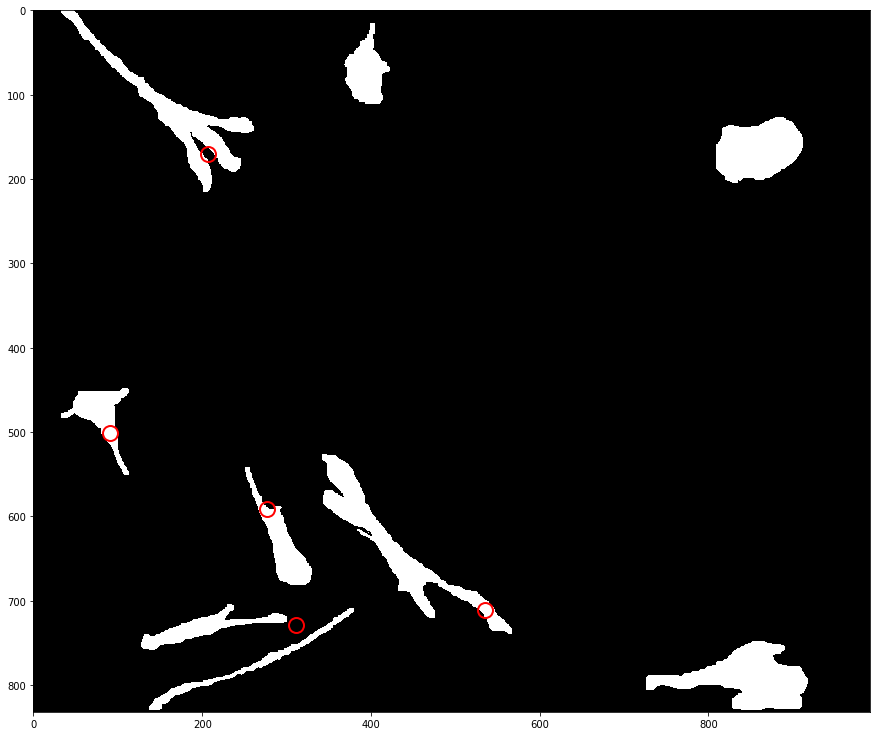

In [134]:
plt.figure()
plt.rcParams['figure.figsize'] = [15, 15]
tp.annotate(cell_df, segmented_groundtruth_stack[0, :, :])

10.6208805056 50.9462601788 255


[Text(0, 0.5, 'count'), Text(0.5, 0, 'mass')]

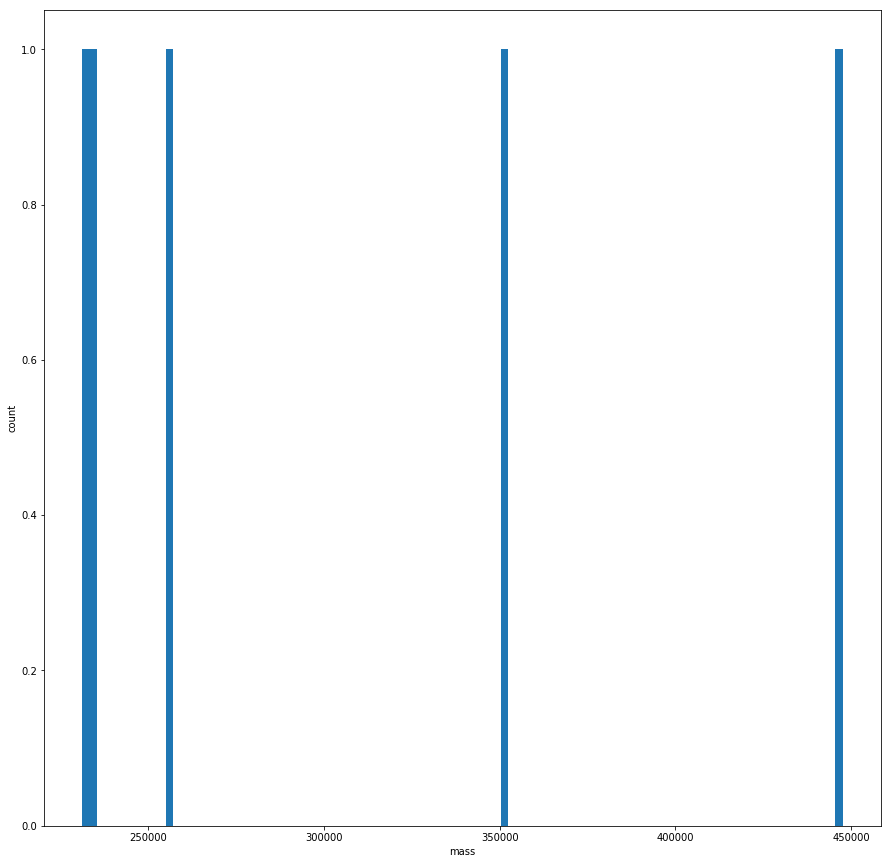

In [135]:
print(np.mean(segmented_groundtruth_stack), np.std(segmented_groundtruth_stack), np.max(segmented_groundtruth_stack))
fig, ax = plt.subplots()
ax.hist(cell_df['mass'], bins=100)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')

In [137]:
frames_df = tp.batch(segmented_groundtruth_stack, diameter=cell_size, minmass=minmass, maxsize=maxsize, percentile=percentile)

Frame 17: 16 features


In [138]:
track_df = tp.link_df(frames_df, 20, memory=3)
print('Before:', track_df['particle'].nunique())
track_df = tp.filter_stubs(track_df, 50)
# Compare the number of particles in the unfiltered and filtered data.
print('After:', track_df['particle'].nunique())
print(track_df.head())

Frame 17: 16 trajectories present.
Before: 322
After: 0
Empty DataFrame
Columns: [y, x, mass, size, ecc, signal, raw_mass, ep, frame, particle]
Index: []


ValueError: DataFrame of trajectories is empty.

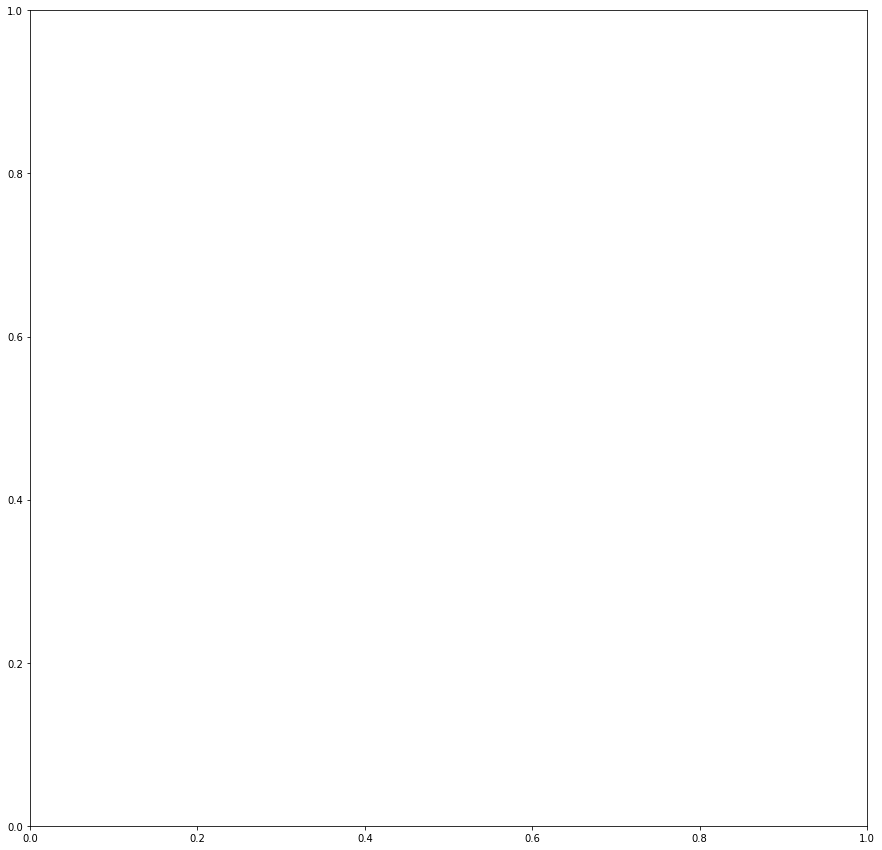

In [139]:
plt.figure()
tp.plot_traj(track_df, superimpose=segmented_groundtruth_stack[0]).set_xlim(300,600)

In [140]:
drift_df = tp.compute_drift(track_df)
plt.figure()
drift_df.plot()

ValueError: 'frame' is both an index level and a column label, which is ambiguous.

In [141]:
track_df = tp.subtract_drift(track_df, drift_df)
plt.figure()
tp.plot_traj(track_df, superimpose=segmented_groundtruth_stack[0]).set_xlim(300,600)

NameError: name 'drift_df' is not defined